In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np
import xarray as xr
import netCDF4 as nc
import math

#di = '/home/claire/Github-forked/MOM6-examples/ocean_only/seamount/sigma_shelf_zstar_grosveld'
di = '/home/claire/Github-forked/MOM6-examples/ocean_only/seamount/ice_to_rock'
#di = '/home/claire/Github-forked/MOM6-examples/ocean_only/seamount/isomip_cut'

NHALO = 4
IC_FILE = 'MOM_IC.nc'
PROG_FILE = 'prog.nc'
ICE_SHELF_FILE = '/INPUT/Ocean1_3D.nc'

### show input ice shelf, if necessary
o1 = xr.open_dataset(di + '/' + ICE_SHELF_FILE)
print(o1)
plt.plot(o1.thick[20].data)
o1.close()

In [4]:
# Prepare axes for 3D plotting of ice shelf IC, topography etc
mic = xr.open_dataset(di + "/"+ IC_FILE)   # MOM6 output
LY, LX = mic.h.data[0].shape[1], mic.h.data[0].shape[2]
YY= np.arange(0, LY, 1)
XX = np.arange(0, LX, 1)
XX, YY = np.meshgrid(XX, YY)

(1, 40, 240)


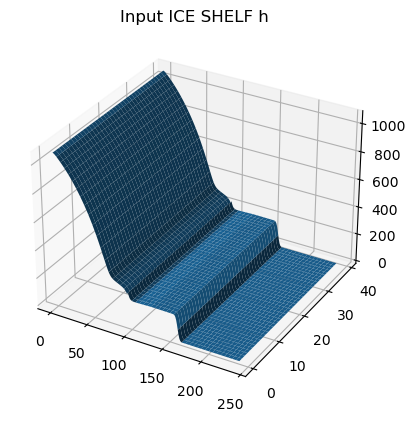

In [5]:
ms = xr.open_dataset(di + '/MOM_Shelf_IC.nc')   # MOM6 output
print(ms.h_shelf.data.shape)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(XX, YY, ms.h_shelf.data[0])
plt.title("Input ICE SHELF h")
plt.show()

(48, 248)


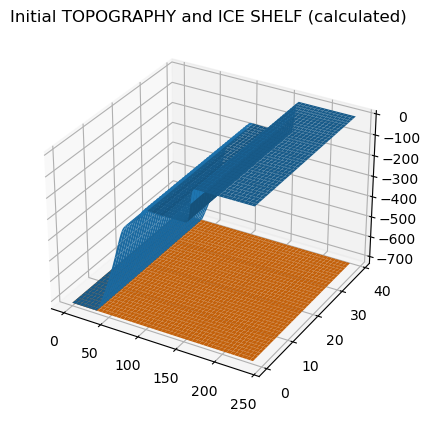

In [6]:
bt = xr.open_dataset(di+'/deb_bathyT.nc') 
h0 = xr.open_dataset(di + '/after_ts_2_h.nc')
ee = np.sum(h0.h.data,axis=0) - bt.bathyT.data
print(ee.shape) # with halo

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(XX, YY, ee[NHALO:-NHALO,NHALO:-NHALO])
topo = ax.plot_surface(XX, YY, -bt.bathyT.data[NHALO:-NHALO,NHALO:-NHALO])
plt.title("Initial TOPOGRAPHY and ICE SHELF (calculated)")
plt.show()

### Plot output h,e,salt etc at chosen time

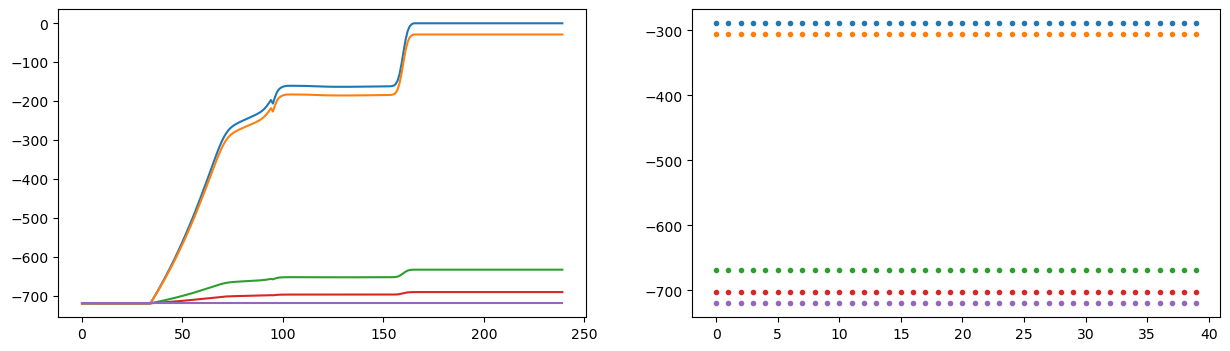

In [7]:
prog = xr.open_dataset(di + '/'+PROG_FILE)
     
fig,axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15,4))
tt=-1; zz= 22; yy=0; xx=71; ll = [0,1,zz,-2,-1] # ll=[0,1,2,3,4,5,10,-3,-2,-1]
for zzz in ll:
    axes[0].plot(prog.e[tt][zzz].data[yy,:])
    axes[1].plot(prog.e[tt][zzz].data[:,xx],'.')

ttt = -1; zzz = 0
plt.plot(prog.salt.data[ttt][zzz][yy,:])

In [8]:
print(np.nanmax(prog.u.data[-1]), np.nanmin(prog.u.data[-1])) # 0.0012509557073082142 -0.0006301157530793094

1.387021436845262e-05 -1.7460288565214358e-06


In [9]:
print(np.nanmax(prog.v.data[-1]), np.nanmin(prog.v.data[-1])) # 0.0012509557073082142 -0.0006301157530793094

2.6473184238351664e-07 -2.6473184238351664e-07


In [10]:
arr = prog.u.data[-1]
ind = np.unravel_index(np.nanargmax(arr),arr.shape)
print(arr[ind])
ind

1.387021436845262e-05


(3, 19, 51)

In [11]:
np.nanmin(prog.e.data[0])

-720.0

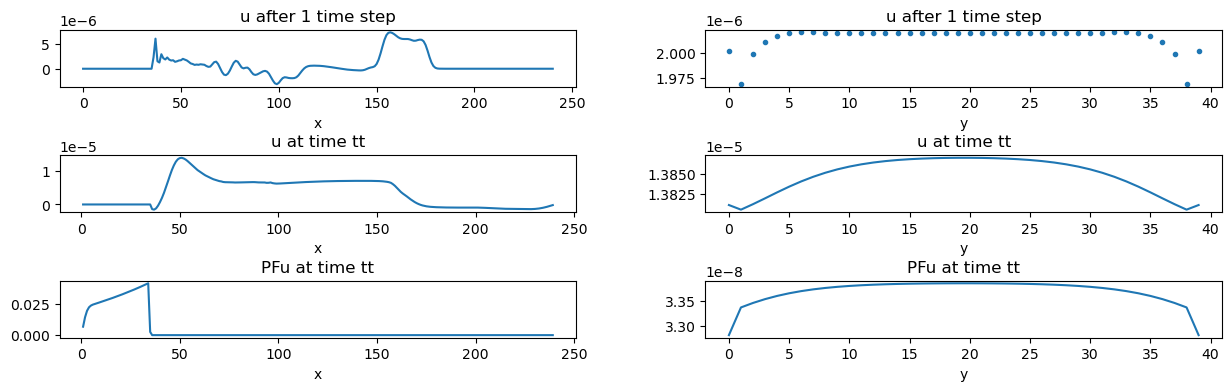

In [13]:
aft = xr.open_dataset(di + '/after_ts_2_u.nc')
mo = xr.open_dataset(di + '/mom.nc')

fig,axes = plt.subplots(nrows = 3, ncols = 2, figsize = (15,4))

tt=-1; zzz=3; yy=19; xx=51
axes[0,0].plot(aft.u.data[zzz,yy+4,4:-4])
axes[0,0].set_xlabel("x")
axes[0,0].set_title("u after 1 time step")
axes[0,1].plot(aft.u.data[zzz,4:-4,xx+4],'.')
axes[0,1].set_xlabel("y")
axes[0,1].set_title("u after 1 time step")
axes[1,0].plot(prog.u[tt][zzz].data[yy,:])
axes[1,0].set_xlabel("x")
axes[1,0].set_title("u at time tt")
axes[1,1].plot(prog.u[tt][zzz].data[:,xx])
axes[1,1].set_xlabel("y")
axes[1,1].set_title("u at time tt")
axes[2,0].plot(mo.PFu[tt][zzz].data[yy,:])
axes[2,0].set_xlabel("x")
axes[2,0].set_title("PFu at time tt")
axes[2,1].plot(mo.PFu[tt][zzz].data[:,xx])
axes[2,1].set_xlabel("y")
axes[2,1].set_title("PFu at time tt")

plt.subplots_adjust(wspace = 0.25, hspace = 1.2)

### Make an "adjusted salt" file

# Open files saved by MOM6 needed to adjust the salt 
bt=xr.open_dataset(di + "/deb_bathyT.nc") # topography file needed to calculate e
h=xr.open_dataset(di + '/after_ts_2_h.nc') # h file before the first time step, but after MOM6 remap
S=xr.open_dataset(di + '/before_finish_MOM_initialization_S.nc') # salt file produced by MOM6, which we want to adjust 

# calculate e and then s as a linear function of e 
S_TOP = 33.8
S_BOTTOM = 34.55
MAXIMUM_DEPTH = 720.0
e=h.h.sum(axis=0).data-bt.bathyT.data
s=(e-h.h.data.cumsum(axis=0) + h.h.data/2)*(S_BOTTOM-S_TOP)/(-MAXIMUM_DEPTH) + S_TOP

# fix the halo points
s[:,:NHALO,:NHALO]=0
s[:,:NHALO,-NHALO:]=0
s[:,-NHALO:,:NHALO]=0
s[:,-NHALO:,-NHALO:]=0

# create new netcdf4 file for the adjusted salt based on the original salt file
nz, ny, nx = S.S.data.shape
new_salt = nc.Dataset(di + "/INPUT/adjustedS.nc", "w", format="NETCDF4")
new_salt.createDimension("nz", nz)
new_salt.createDimension("ny", ny)
new_salt.createDimension("nx", nx)
temp = new_salt.createVariable("S","f8",("nz","ny","nx"))
temp[:,:,:]=s
new_salt.close()

### Make new  topography and ice shelf files, if necessary

#### use ISOMIP ice shelf as model
old = nc.Dataset(di + "/INPUT/Ocean1_3D.nc", "r")
print(old)

b3 = old.variables["thick"][19,:]
for i in range(240):
   b3[i]=350-350.0/125.0*i
b1 = np.maximum(b3, 50)

zero_position = np.where(b1==0)[0]
b2 = old.variables["area"][19,:]
b2[zero_position]=0 # Grosveld 2
#b2[:]=4000000.   # Grosveld 1

b5 = old.variables["area"][19,:]
for i in range(240):
   b5[i]=500+(700-500)/125.0*i
b4 = np.minimum(b5, 700)

plt.plot(b1)

### New shelf: Take an ISOMIP cross-section, smooth it linearly, and replicate non-uniformly into a dome
### <font color='red'>Discontinuos h_shelf jump in x</font>

old_shelf = nc.Dataset(di + "/INPUT/Ocean1_3D.nc", "r") #!use ISOMIP ice shelf as model
print(old_shelf)

b3 = old_shelf.variables["thick"][6,:]
b5 = old_shelf.variables["area"][6,:]

x=np.arange(240)
bb3=np.maximum(1000-6.2*x,0) # "smoothed" version of b3

new_shelf = nc.Dataset(di + "/INPUT/shelfX.nc", "w", format="NETCDF4")
new_shelf.createDimension("ny", 40)
new_shelf.createDimension("nx", 240)
new_shelf.createVariable("thick","f8",("ny","nx"))
new_shelf.createVariable("area","f8",("ny","nx"))

for ii in range(40):
    new_shelf["area"][ii,:] = b5
    new_shelf["thick"][ii,:] = bb3+(19.5-ii)**2*0.5

new_shelf["thick"][:,math.ceil(1000/6.2):] = 0

new_shelf.close()

zzz=np.sqrt((XX)**2+(YY)**2)

ms = xr.open_dataset(di + '/MOM_Shelf_IC.nc')   # MOM6 output
print(ms.h_shelf.data.shape)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(XX, YY, zzz)
plt.title("Input ICE SHELF h (MOM6 Output)")
plt.show()

ZZ.shape

#plt.plot(b3)
#plt.plot(bb3)
bb3[164]

#for ii in range(1,40,4):
#    plt.plot(bb3 +(19.5-ii)**2*0.3)
    
#bb4 = np.zeros(240)

ii = 30
bb4 = bb3 +(19.5-ii)**2*0.3

iip = abs(20-ii)
for j in range(iip):
    bb4[164-j] = bb4[164-iip]*j/iip
    
bb4[164:] = 0
plt.plot(bb4)
plt.plot(bb3)

### New shelf: Take an ISOMIP cross-section, smooth it quadratically, and replicate non-uniformly into a dome
### <font color='red'>Discontinuos h_shelf jump in x</font>

#### use ISOMIP ice shelf as model
old_shelf = nc.Dataset(di + "/INPUT/Ocean1_3D.nc", "r")
print(old_shelf)

b3 = old_shelf.variables["thick"][6,:]
b5 = old_shelf.variables["area"][6,:]

x=np.arange(240)
bb3=0.5*np.maximum(0.02*(x-250)**2-150,0) # "smoothed" version of b3

new_shelf = nc.Dataset(di + "/INPUT/shelfX.nc", "w", format="NETCDF4")
new_shelf.createDimension("ny", 40)
new_shelf.createDimension("nx", 240)
new_shelf.createVariable("thick","f8",("ny","nx"))
new_shelf.createVariable("area","f8",("ny","nx"))

for ii in range(40):
    new_shelf["area"][ii,:] = b5
    bb4 = bb3 +(19.5-ii)**2*0.3
    iip = abs(20-ii)
    for j in range(iip):
        bb4[164-j] = bb4[164-iip]*j/iip
    bb4[164:] = 0
    new_shelf["thick"][ii,:] = bb4
    
    #new_shelf["thick"][ii,:] = bb3 +(19.5-ii)**2*0.3 # if 19.5 >= ii else bb3

new_shelf["thick"][:, 164:] = 0
new_shelf["area"][:, 164:] = 0

new_shelf.close()

### New shelf: Take an ISOMIP cross-section and replicate non-uniformly into a dome
### <font color='red'>Steep h_shelf jump in x, non-uniform in y</font>

old_shelf = nc.Dataset(di + "/INPUT/Ocean1_3D.nc", "r") #! use ISOMIP ice shelf as model
print(old_shelf)

b3 = old_shelf.variables["thick"][6,:]
b5 = old_shelf.variables["area"][6,:]

new_shelf = nc.Dataset(di + "/INPUT/shelfX.nc", "w", format="NETCDF4")
new_shelf.createDimension("ny", 40)
new_shelf.createDimension("nx", 240)
new_shelf.createVariable("thick","f8",("ny","nx"))
new_shelf.createVariable("area","f8",("ny","nx"))

for ii in range(40):
    new_shelf["area"][ii,:] = b5
    new_shelf["thick"][ii,:] = b3+(19.5-ii)**2*0.3

new_shelf["area"][:,:] = 4000000. #! extend shelf all the way
new_shelf.close()

In [2]:
### New shelf: Take an ISOMIP cross-section and replicate uniformly in y direction
### <font color='green'>Steep h_shelf jump in x, but uniform in y</font>

old_shelf = nc.Dataset(di + "/INPUT/Ocean1_3D.nc", "r") #! use ISOMIP ice shelf as model
print(old_shelf)

b3 = old_shelf.variables["thick"][6,:]
b5 = old_shelf.variables["area"][6,:]

new_shelf = nc.Dataset(di + "/INPUT/shelfX.nc", "w", format="NETCDF4")
new_shelf.createDimension("ny", 40)
new_shelf.createDimension("nx", 240)
new_shelf.createVariable("thick","f8",("ny","nx"))

new_shelf.createVariable("area","f8",("ny","nx"))

for ii in range(40):
    new_shelf["area"][ii,:] = b5
    new_shelf["thick"][ii,:] = b3

new_shelf.close()

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    dimensions(sizes): ny(40), nx(240)
    variables(dimensions): float64 thick(ny, nx), float64 area(ny, nx)
    groups: 


### New shelf: Cut the ISOMIP ice shelf in half

old_shelf = nc.Dataset(di + "/INPUT/Ocean1_3D.nc", "r") #! use ISOMIP ice shelf as model
print(old_shelf)

thi = old_shelf.variables["thick"][:,:]
 
ar = old_shelf.variables["area"][:,:]

print(thi[:,120:].shape)

new_shelf = nc.Dataset(di + "/INPUT/shelfX.nc", "w", format="NETCDF4")
new_shelf.createDimension("ny", 40)
new_shelf.createDimension("nx", 120)
new_shelf.createVariable("thick","f8",("ny","nx"))

new_shelf.createVariable("area","f8",("ny","nx"))

new_shelf["area"][:,:] = ar[:,120:]
new_shelf["thick"][:,:] = thi[:,120:]

new_shelf.close()

### New topography
#### use ISOMIP ice shelf as model
old_topo = nc.Dataset(di + "/deb_bathyT.nc", "r")
print(old_topo)

ba = old_topo.variables["bathyT"][:,:]

ba[4:-4,4+120:-4].shape

new_topog = nc.Dataset(di + "/INPUT/topogX.nc", "w", format="NETCDF4")
new_topog.createDimension("ny", 40)
new_topog.createDimension("nx", 120)
new_topog.createVariable("depth","f8",("ny","nx"))

new_topog["depth"][:,:] = ba[4:-4,4+120:-4]
    
new_topog.close()

### Make thickness file to use with THICKNESS_CONFIG (without applying salt adjustment first)
#### Use with HACK_MODE=True and REMAP_AFTER_INITIALIZATION=False
#### This is an alternative to ADJUST_SALT=True. It is MPI-safe!!!

In [3]:
oldold = nc.Dataset(di + "/after_ts_1_h.nc", "r") # h file before the first time step, but after MOM6 remap

new_thick = nc.Dataset(di + "/INPUT/thickness.nc", "w", format="NETCDF4")
new_thick.createDimension("nz", 25)
new_thick.createDimension("ny", 40)
new_thick.createDimension("nx", 240)
new_thick.createVariable("h","f8",("nz","ny","nx"))

new_thick["h"][:,:,:] = oldold.variables["h"][:,NHALO:-NHALO,NHALO:-NHALO]

new_thick.close()

In [ ]:
ic = xr.open_dataset(di + '/MOM_IC.nc')

### New shelf: Make ISOMIP ice shelf half as massive

old_shelf = nc.Dataset(di + "/INPUT/Ocean1_3D.nc", "r") #! use ISOMIP ice shelf as model
print(old_shelf)

thi = old_shelf.variables["thick"][:,:]
ar = old_shelf.variables["area"][:,:]

print(thi[:,120:].shape)

new_shelf = nc.Dataset(di + "/INPUT/shelfX.nc", "w", format="NETCDF4")
new_shelf.createDimension("ny", 40)
new_shelf.createDimension("nx", 240)
new_shelf.createVariable("thick","f8",("ny","nx"))

new_shelf.createVariable("area","f8",("ny","nx"))

new_shelf["area"][:,:] = ar
new_shelf["thick"][:,:] = thi/2

new_shelf.close()